In [1]:
from datetime import datetime

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

from CCdb   import _default_reference_file as references
from CCio   import load_hdf
from CCcore import integrate_peak
from CCplot import auto_plot_style

In [2]:
%matplotlib inline
auto_plot_style()

In [3]:
ZnO = load_hdf(references, None, "ZnO")

In [4]:
ZnO.tail()

em_wl  counts     timestamp  grating_mono  grating_spec  \
348923  1269.5112  3747.0  1.650782e+09             1             2   
348924  1270.0167  3765.0  1.650782e+09             1             2   
348925  1270.5221  3731.0  1.650782e+09             1             2   
348926  1271.0275  3781.0  1.650782e+09             1             2   
348927  1271.5328  3752.0  1.650782e+09             1             2   

       crystal_id  ex_wl  exposure    bls   rate    power0           dq0  \
348923  Sp_B1_004    400       1.0  307.3  307.3  0.000002  9.379187e-11   
348924  Sp_B1_004    400       1.0  326.5  326.5  0.000002  9.965195e-11   
348925  Sp_B1_004    400       1.0  285.5  285.5  0.000002  8.713823e-11   
348926  Sp_B1_004    400       1.0  346.5  346.5  0.000002  1.057562e-10   
348927  Sp_B1_004    400       1.0  309.1  309.1  0.000002  9.434125e-11   

                  datetime        date  
348923 2022-04-24 09:25:24  2022-04-24  
348924 2022-04-24 09:25:24  2022-04-24  
348925 2022-04-24 09:25:24  2022-04-24  
348926 2022-04-24 09:25:24  2022-04-24  
348927 2022-04-24 09:25:24  2022-04-24

In [5]:
plt.figure(figsize=(15, 5))
p = ZnO.groupby("datetime", as_index=False).agg("first")
plt.plot(p.datetime, p.power0, ".:")
plt.ylim(-1e-6, p.power0.max() * 1.1)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Average power ($\mu$W)")
plt.title("Power vs time")

Text(0.5, 1.0, 'Power vs time')

In [6]:
ZnO.to_csv("/home/gonzalo/data/CC/ZnO.csv")

# ZnO

In [7]:
column    = "bls"
dates     = []
integrals = []
             
for t, data in ZnO.groupby("datetime"):
    i = integrate_peak(data, 400, 900, column)
    dates = np.append(dates, t)
    integrals = np.append(integrals, i)

times  = [d.timestamp() for d in dates]
errors = integrals**0.5

In [8]:
integrals[-5:]/1e6

array([6.8007454, 6.6630633, 6.563582 , 6.5368838, 6.4997751])

Text(0.5, 1.0, 'Peak integral vs time')

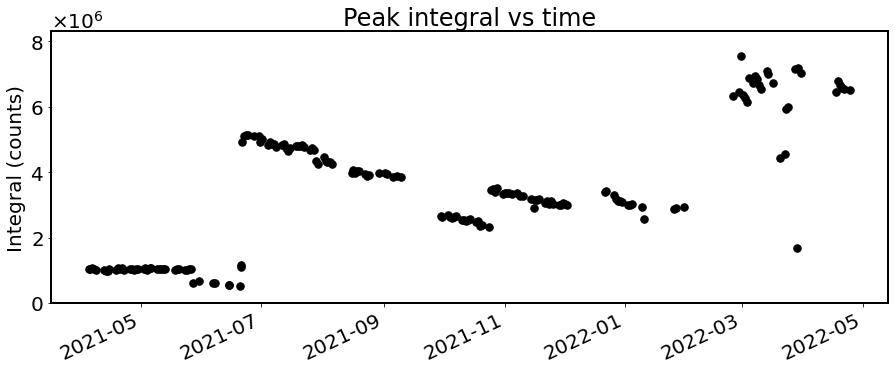

In [9]:
plt.figure(figsize=(15, 5))
plt.errorbar(dates, integrals, errors, fmt=".k")
plt.ylim(0, integrals.max() * 1.1)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Integral (counts)")
plt.title("Peak integral vs time")

In [10]:
df = pd.DataFrame(dict(timestamp = times,
                       date      = dates,
                       integral  = integrals,
                       error     = errors))
df.to_hdf("/home/gonzalo/data/CC/pre-annealing-experiment/power_normalization.h5", "/integrals")
df

timestamp                date   integral        error
0    1.617557e+09 2021-04-04 17:23:44  1035637.5  1017.662763
1    1.617614e+09 2021-04-05 09:09:19  1056676.0  1027.947469
2    1.617700e+09 2021-04-06 09:01:50  1059831.4  1029.481131
3    1.617786e+09 2021-04-07 09:07:10  1058992.0  1029.073370
4    1.617880e+09 2021-04-08 11:08:58  1012835.2  1006.397138
..            ...                 ...        ...          ...
175  1.650300e+09 2022-04-18 16:38:55  6800745.4  2607.823882
176  1.650379e+09 2022-04-19 14:41:29  6663063.3  2581.291014
177  1.650456e+09 2022-04-20 11:52:49  6563582.0  2561.948868
178  1.650540e+09 2022-04-21 11:26:47  6536883.8  2556.733033
179  1.650792e+09 2022-04-24 09:25:24  6499775.1  2549.465650

[180 rows x 4 columns]

In [11]:
int_f = interp1d(times, integrals)

t = np.linspace(dates.min().timestamp(), dates.max().timestamp(), 201)
i = int_f(t)
d = np.array(list(map(datetime.fromtimestamp, t)))

Text(0, 0.5, 'ZnO peak integral (counts)')

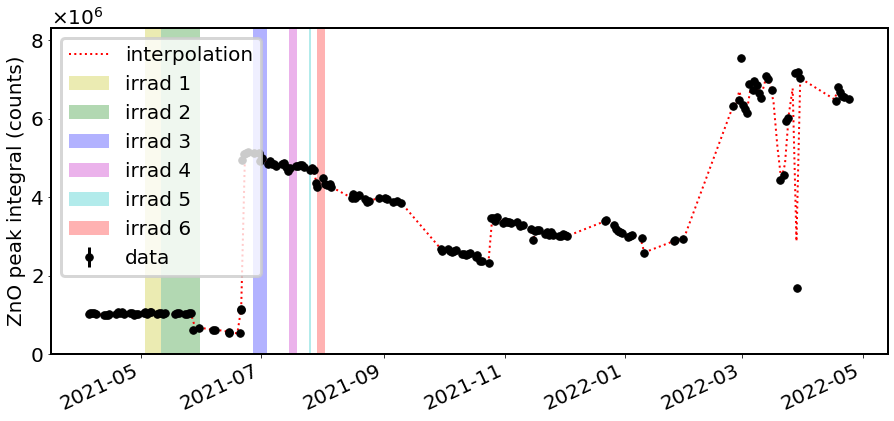

In [12]:
plt.figure(figsize=(15, 6))
plt.errorbar(dates, integrals, errors, fmt=".k", label="data")
plt.plot    (    d,         i, "r:", label="interpolation", lw=2)
plt.ylim(0, integrals.max() * 1.1)
plt.fill_betweenx(plt.ylim(), datetime(2021, 5,  3), datetime(2021, 5, 11), facecolor="y", alpha=0.3, label="irrad 1")
plt.fill_betweenx(plt.ylim(), datetime(2021, 5, 11), datetime(2021, 5, 31), facecolor="g", alpha=0.3, label="irrad 2")
plt.fill_betweenx(plt.ylim(), datetime(2021, 6, 27), datetime(2021, 7,  4), facecolor="b", alpha=0.3, label="irrad 3")
plt.fill_betweenx(plt.ylim(), datetime(2021, 7, 15), datetime(2021, 7, 19), facecolor="m", alpha=0.3, label="irrad 4")
plt.fill_betweenx(plt.ylim(), datetime(2021, 7, 25), datetime(2021, 7, 26), facecolor="c", alpha=0.3, label="irrad 5")
plt.fill_betweenx(plt.ylim(), datetime(2021, 7, 29), datetime(2021, 8,  2), facecolor="r", alpha=0.3, label="irrad 6")

plt.legend()
plt.xticks(rotation=25, ha="right")
plt.ylabel("ZnO peak integral (counts)")

(6000000.0, 8000000.0)

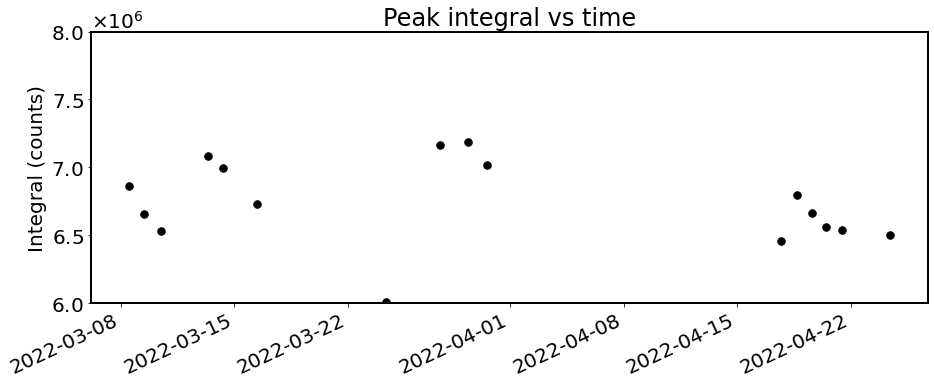

In [16]:
plt.figure(figsize=(15, 5))
n = 20
plt.errorbar(dates[-n:], integrals[-n:], errors[-n:], fmt=".k")
plt.ylim(0, integrals.max() * 1.1)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Integral (counts)")
plt.title("Peak integral vs time")
plt.ylim(6e6, 8e6)

(1.5e-06, 1.75e-06)

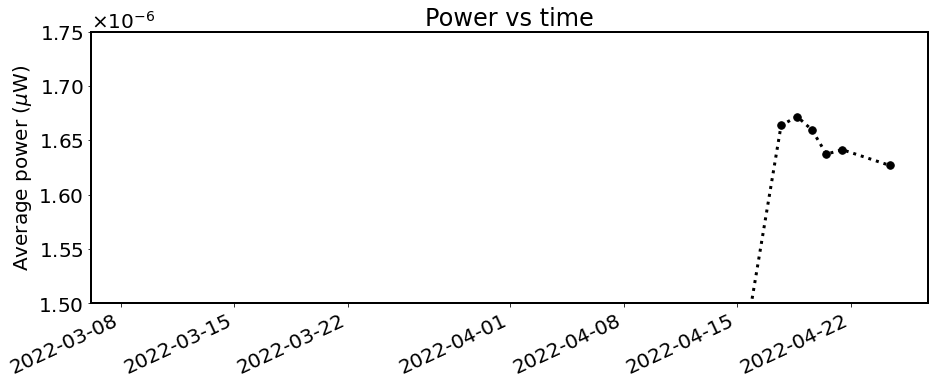

In [23]:
plt.figure(figsize=(15, 5))
p = ZnO.groupby("datetime", as_index=False).agg("first")
plt.plot(p.datetime.iloc[-20:], p.power0[-20:], ".:")
plt.ylim(-1e-6, p.power0.max() * 1.1)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Average power ($\mu$W)")
plt.title("Power vs time")
plt.ylim(1.5e-6, 1.75e-6)